# Identifying Optotagged Units
In some transgenic mice, particular types of neurons express a trait whereby they will fire in response to direct laser stimulation. These mice express light-gated ion channels (channelrhodopsins) in a Cre-dependent manner, thus units that fire action potentials in response to light pulses are likely to express the gene of interest. The particular form of laser stimulation is stored in the `optogenetic_stimulation` table of our NWB files. 

Identifying these expressive neurons is called *Optotagging*. Optotagging makes it possible to link the in vivo spike recordings of neuronal units to genetically defined cell classes. Doing this analysis with the optogenetic stimulus information is relatively similar to the analysis in [Visualizing Neuronal Unit Responses](../visualization/visualize_unit_responses.ipynb). To do this, we take all the relevant stimulation times from the stimulus table and identify which neuronal units fire within a predetermined window of time following the stimulus times. Neurons that spike more frequently and consistently after stimulus are likely to be optotagged.

### Environment Setup
⚠️**Note: If running on a new environment, run this cell once and then restart the kernel**⚠️

In [1]:
import warnings
warnings.filterwarnings('ignore')

try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
from math import isclose
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import mannwhitneyu
from scipy.stats import median_abs_deviation
from scipy.stats import kstest

%matplotlib inline

### Downloading Ecephys File
The example file we use is from the Allen Institute's **Visual Coding - Neuropixels** dataset. To specify your own file to use, set `dandiset_id` and `dandi_filepath` to be the respective dandiset id and dandi filepath of the file you're interested in. When accessing an embargoed dataset, set `dandi_api_key` to be your DANDI API key. If you want to stream a file instead of downloading it, change `dandi_download_open` to `dandi_stream_open`. Checkout [Streaming an NWB File with remfile](../basics/stream_nwb.ipynb) for more information on this.

In [3]:
dandiset_id = "000022"
sst_dandi_filepath = "sub-774672354/sub-774672354_ses-794812542.nwb"
wt_dandi_filepath = "sub-753795604/sub-753795604_ses-767871931.nwb"
download_loc = "."
dandi_api_key = None

In [4]:
# This can sometimes take a while depending on the size of the file
sst_io = dandi_download_open(dandiset_id, sst_dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
sst_nwb = sst_io.read()

wt_io = dandi_download_open(dandiset_id, wt_dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
wt_nwb = wt_io.read()

File already exists
Opening file
File already exists
Opening file


### Extracting Optogenetic Stimulus Data and Units Data
The two components needed for this analysis are the `optogenetic_stimulation` table and the `Units` table. The optogenetic stimulus table contains the intervals during which laser stimulation is delivered to the brain. The primary property we will use from this table is `start_time`, which contains the times that stimulus is delivered. From the `Units` table, we will extract the `spike_times` which will be aligned relative to a predefined window of time around each stimulus time to determine if it occurred in response to the stimulus. These tables are retrieved and printed below.

In [5]:
wt_stim_table = wt_nwb.processing["optotagging"]["optogenetic_stimulation"]
sst_stim_table = sst_nwb.processing["optotagging"]["optogenetic_stimulation"]
sst_stim_table[:10]

,start_time,condition,level,stop_time,stimulus_name,duration,tags,timeseries
id,,,,,,,,
0,9209.13926,half-period of a cosine wave,1.7,9210.13926,raised_cosine,1.000,[optical_stimulation],"[(0, 1, optotagging pynwb.base.TimeSeries at 0..."
1,9211.09935,a single square pulse,1.3,9211.10435,pulse,0.005,[optical_stimulation],"[(1, 1, optotagging pynwb.base.TimeSeries at 0..."
2,9212.95940,a single square pulse,1.7,9212.96940,pulse,0.010,[optical_stimulation],"[(2, 1, optotagging pynwb.base.TimeSeries at 0..."
3,9214.66951,a single square pulse,1.7,9214.67951,pulse,0.010,[optical_stimulation],"[(3, 1, optotagging pynwb.base.TimeSeries at 0..."
4,9216.74957,half-period of a cosine wave,1.7,9217.74957,raised_cosine,1.000,[optical_stimulation],"[(4, 1, optotagging pynwb.base.TimeSeries at 0..."
5,9218.79964,a single square pulse,1.3,9218.80464,pulse,0.005,[optical_stimulation],"[(5, 1, optotagging pynwb.base.TimeSeries at 0..."
6,9220.54970,half-period of a cosine wave,1.3,9221.54970,raised_cosine,1.000,[optical_stimulation],"[(6, 1, optotagging pynwb.base.TimeSeries at 0..."
7,9222.65981,a single square pulse,2.0,9222.66481,pulse,0.005,[optical_stimulation],"[(7, 1, optotagging pynwb.base.TimeSeries at 0..."
8,9224.59986,a single square pulse,1.7,9224.60486,pulse,0.005,[optical_stimulation],"[(8, 1, optotagging pynwb.base.TimeSeries at 0..."


In [6]:
set(sst_stim_table.duration)

{0.0049999999991996455, 0.01000000000021828, 1.0}

In [7]:
wt_units_table = wt_nwb.units
sst_units_table = sst_nwb.units
sst_units_table[:10]

,PT_ratio,spread,presence_ratio,recovery_slope,silhouette_score,waveform_halfwidth,cluster_id,firing_rate,amplitude_cutoff,waveform_duration,...,max_drift,cumulative_drift,local_index,velocity_below,amplitude,nn_hit_rate,isi_violations,spike_times,spike_amplitudes,waveform_mean
id,,,,,,,,,,,,,,,,,,,,,
951082751,0.419765,40.0,0.99,-0.122291,NaN,0.137353,0,7.104418,0.237403,0.206030,...,14.23,330.92,0,NaN,71.376630,0.990667,0.308011,"[4.404383589226281, 8.67118909163238, 11.03942...","[0.00010935638773041407, 0.0001053127062613349...","[[0.0, -2.834130000000002, -7.155524999999987,..."
951083991,0.535828,60.0,0.99,-0.074917,0.047790,0.109883,435,0.278519,0.130559,0.206030,...,32.94,669.23,417,0.000000,91.741455,0.453333,0.000000,"[8.196121812326329, 21.342438765612467, 23.426...","[8.26202146584441e-05, 7.495588582432538e-05, ...","[[0.0, -4.334850000000012, -0.9492600000000104..."
951082759,0.853006,50.0,0.99,-0.130682,0.221266,0.082412,3,8.925235,0.001414,0.151089,...,41.73,376.08,3,0.000000,107.288220,0.999333,0.008631,"[4.6698505982350795, 4.698917302385716, 4.7766...","[0.00013007537754279887, 0.0001180359600428186...","[[0.0, -1.106819999999991, -4.045664999999994,..."
951082767,0.348855,40.0,0.99,-0.120575,0.179655,0.068677,6,15.335853,0.053171,0.109883,...,23.85,367.74,6,0.000000,107.460210,0.998667,0.126358,"[4.6178505311766, 5.357818152094017, 5.5837184...","[8.749199442943392e-05, 8.611238834643928e-05,...","[[0.0, 1.6528199999999984, -1.7840550000000244..."
951082786,0.579262,60.0,0.99,-0.169156,0.160511,0.164824,13,1.111425,0.002400,0.274707,...,25.71,134.04,13,-0.206030,164.961225,1.000000,0.000000,"[5.93865223446196, 9.150423042978373, 17.33643...","[0.0001752243457523341, 0.00017500487733309024...","[[0.0, -3.826485000000007, -1.3634400000000007..."
951082795,0.303918,60.0,0.99,-0.053188,0.179032,0.137353,16,11.282504,0.002560,0.315913,...,17.86,101.38,16,-0.961474,84.012630,1.000000,0.009002,"[3.84931620675334, 3.861782889496847, 3.895916...","[8.129339295037826e-05, 9.441664431033754e-05,...","[[0.0, 1.0198500000000168, 2.013375000000001, ..."
951082801,0.553492,80.0,0.99,-0.047044,0.241507,0.329648,18,0.282289,0.161206,0.384590,...,20.87,272.07,18,-0.392438,65.208390,0.940171,0.479336,"[14.247296282493597, 36.373158148994705, 37.61...","[0.00010133442324299622, 8.54276743967337e-05,...","[[0.0, -0.41125499999998905, -2.76431999999999..."
951082810,0.614285,50.0,0.99,-0.074530,0.082241,0.123618,21,5.301027,0.468892,0.247236,...,19.15,180.21,21,-0.686767,68.146260,0.958667,0.086994,"[3.8538828793091167, 4.094716523217777, 5.0348...","[0.00011609751977622408, 0.0001022201410941623...","[[0.0, 0.8874450000000262, 0.13923000000000307..."
951083999,0.812881,50.0,0.99,-0.089071,0.045504,0.192295,437,4.835504,0.035226,0.288442,...,19.72,273.67,419,-0.686767,85.016100,0.852000,0.148657,"[3.726249381381607, 3.982783045536769, 4.14044...","[0.00016281725046406152, 0.0001520994002522755...","[[0.0, 2.6876850000000037, 1.1136450000000053,..."


### Selecting Units and Stimuli
Here subsets of the data can be selected for analysis. The important properties of the stimulus table shown above are, `condition` (type of laser pulse delivered), the voltage `level`, and the `duration`. Below, you can define `stim_select` to select individual rows of the table based on these properties.

The same can be done for the units table by defining the function `unit_select`. For information on the properties of the `Units` table, see [Visualizing Unit Quality Metrics](../visualization/visualize_unit_metrics.ipynb)

In [8]:
stim_duration = 0.01

In [9]:
def get_stim_times(stim_table):
    stim_select = lambda row: isclose(float(row.duration), stim_duration)
    # stim_select = lambda row: True
    stim_times = [float(row.start_time) for row in stim_table if stim_select(row)]
    return stim_times

In [10]:
wt_stim_times = get_stim_times(wt_stim_table)
sst_stim_times = get_stim_times(sst_stim_table)

print("Selected stim times from Wildtype file:", len(wt_stim_times))
print("Selected stim times from SST file:", len(sst_stim_times))

Selected stim times from Wildtype file: 45
Selected stim times from SST file: 75


In [11]:
def get_spike_times(units_table):
    # unit_select = lambda row: float(row.firing_rate) > 4
    # unit_select = lambda row: True
    # units_spike_times = [row.spike_times.iloc[0] for row in units_table if unit_select(row)]
    units_spike_times = units_table["spike_times"]
    return units_spike_times

In [12]:
wt_spike_times = get_spike_times(wt_units_table)
sst_spike_times = get_spike_times(sst_units_table)

print("# Neurons from Wildtype file:", len(wt_spike_times))
print("# Neurons from SST file:", len(sst_spike_times))

# Neurons from Wildtype file: 2685
# Neurons from SST file: 2688


### Plotting Unit Responses
Here, the spike times of the selected units are used along with the selected stimulus times. In this example, the spike times are aligned to a window from -0.01 to 0.025 seconds around the stimulus start times and counted into bins. The result is a 2D array of spike counts over the time window for each unit. The 3D `spike_matrix` and 2D `spike_counts` arrays will be used for further analysis later on.  Also below is the function `show_counts`. This will be used with `spike_counts` and variations of this array to display various plots. You may change the variables in the next cell to suit your analysis

In [13]:
# period to exclude from analysis before and after the stimulus event 
censor_period = 0.002

# bin size for counting spikes
time_resolution = 0.001

# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
# the baseline interval will be window_start_time to 0-censor_period
window_start_time = -0.01
window_end_time = 0.025

In [14]:
def get_spike_matrix(stim_times, units_spike_times, bin_edges):
    time_resolution = np.mean(np.diff(bin_edges))
    # 3D spike matrix to be populated with spike counts
    spike_matrix = np.zeros((len(units_spike_times), len(stim_times), len(bin_edges)-1))

    # populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
    for unit_idx in range(len(units_spike_times)):
        spike_times = units_spike_times[unit_idx]

        for stim_idx, stim_time in enumerate(stim_times):
            # get spike times that fall within the bin's time range relative to the stim time        
            first_bin_time = stim_time + bin_edges[0]
            last_bin_time = stim_time + bin_edges[-1]
            first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
            spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

            # convert spike times into relative time bin indices
            bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
            
            # mark that there is a spike at these bin times for this unit on this stim trial
            for bin_idx in bin_indices:
                spike_matrix[unit_idx, stim_idx, bin_idx] += 1

    return spike_matrix

In [15]:
def get_spike_counts(stim_times, spike_times, censor_period, stim_duration, time_resolution, window_start_time, window_end_time):
    # time bins used
    n_bins = int((window_end_time - window_start_time) / time_resolution)
    bin_edges = np.linspace(window_start_time, window_end_time, n_bins, endpoint=True)

    # calculate baseline and stimulus interval indices for use later
    stim_start_time = censor_period
    stim_end_time = stim_duration - censor_period
    stim_start_idx = int((stim_start_time - (bin_edges[0])) / time_resolution)
    stim_end_idx = int((stim_end_time - (bin_edges[0])) / time_resolution)
    bl_start_idx = 0
    bl_end_idx = int((0-censor_period-bin_edges[0]) / time_resolution)

    spike_matrix = get_spike_matrix(stim_times, spike_times, bin_edges)

    # aggregate all stim trials to get total spikes by unit over time
    spike_counts = np.sum(spike_matrix, axis=1)

    return spike_counts, spike_matrix, bin_edges, bl_start_idx, bl_end_idx, stim_start_idx, stim_end_idx

In [16]:
# get spike counts array and related info for both SST and Wildtype files
sst_spike_counts, sst_spike_matrix, sst_bin_edges, sst_bl_start, sst_bl_end, sst_stim_start, sst_stim_end = get_spike_counts(sst_stim_times, sst_spike_times, censor_period, stim_duration, time_resolution, window_start_time, window_end_time)
wt_spike_counts, wt_spike_matrix, wt_bin_edges, wt_bl_start, wt_bl_end, wt_stim_start, wt_stim_end = get_spike_counts(wt_stim_times, wt_spike_times, censor_period, stim_duration, time_resolution, window_start_time, window_end_time)

print(sst_spike_counts.shape)
print(wt_spike_counts.shape)

(2688, 34)
(2685, 34)


### Plotting Spike Counts
The plot below show how different units respond to the optogenetic laser stimulation that was selected. It can be seen below that among the SST units, many cells show responsive activity following the laser activation, while the wildtype (non-genetically modified cells) don't show any significant response to the optogenetic stimulation.

**Note that there are also some units that seem to fire at the very beginning and/or very end of the light pulse. These spikes are almost certainly artifactual, as it takes at least 1 ms to generate a true light-evoked action potential. To manage this, we use the censor period to constrain the stimulus period analyzed, indicated by the dotted white lines.**

In [17]:
### method to show plot of spike counts of units over time

def show_counts(counts_array, bin_edges, figax=None, stim_bounds=[], title="", c_label="", vmin=None, vmax=None):
    if figax == None:
        fig, ax = plt.subplots(figsize=(6,10)) # change fig size for different plot dimensions
    else:
        fig, ax = figax

    img = ax.imshow(counts_array, 
                    extent=[np.min(bin_edges), np.max(bin_edges), 0, len(counts_array)], 
                    aspect="auto",
                    vmin=vmin,
                    vmax=vmax) # change vmax to get a better depiction of your data

    for bound in stim_bounds:
        ax.plot([bound, bound],[0, len(counts_array)], ':', color='white', linewidth=1.0)

    ax.set_xlabel("Time relative to stimulus onset (s)")
    ax.set_ylabel("Unit #")
    ax.set_title(title)

    cbar = fig.colorbar(img, shrink=0.5)
    cbar.set_label(c_label)

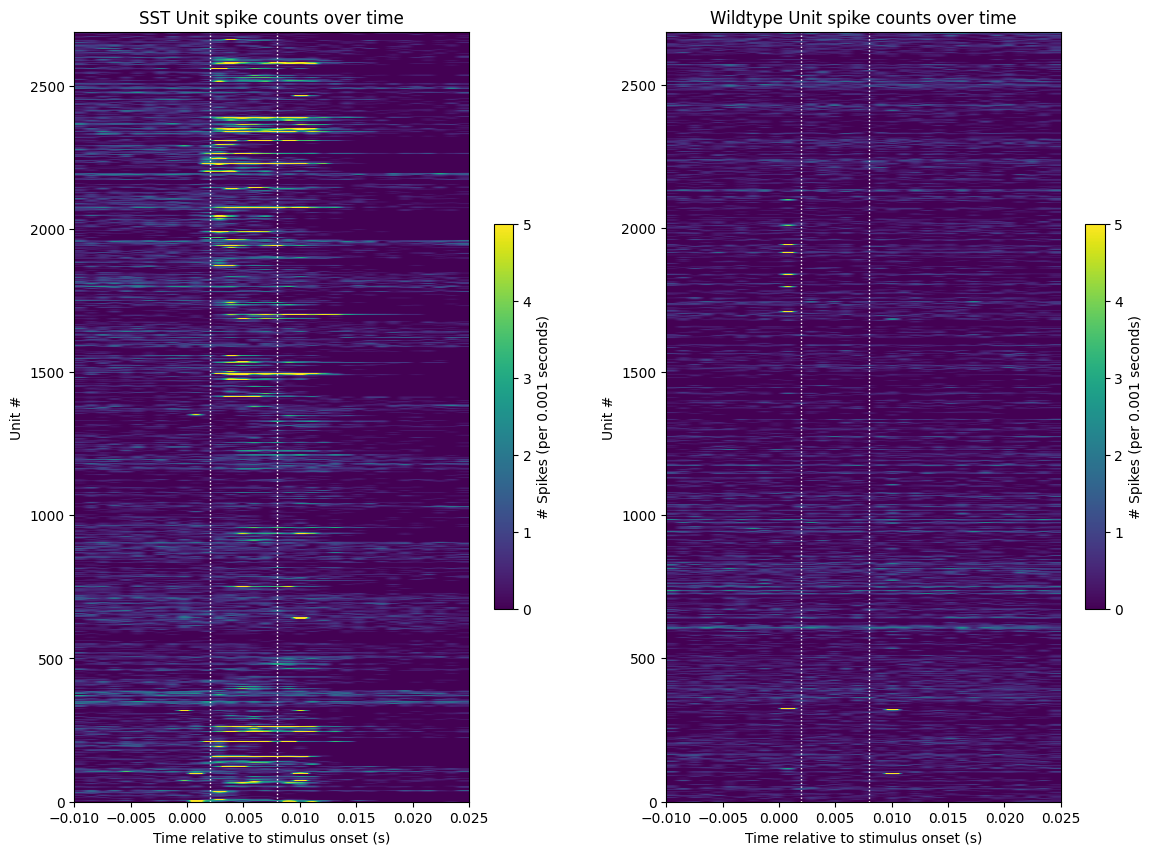

In [18]:
fig, axes = plt.subplots(1,2, figsize=(14,10))

show_counts(sst_spike_counts,
            sst_bin_edges,
            figax = (fig, axes[0]),
            stim_bounds=[censor_period, stim_duration-censor_period],
            title="SST Unit spike counts over time",
            c_label=f"# Spikes (per {time_resolution} seconds)",
            vmin=0,
            vmax=5)

show_counts(wt_spike_counts,
            wt_bin_edges,
            figax = (fig, axes[1]),
            stim_bounds=[censor_period, stim_duration-censor_period],
            title="Wildtype Unit spike counts over time",
            c_label=f"# Spikes (per {time_resolution} seconds)",
            vmin=0,
            vmax=5)

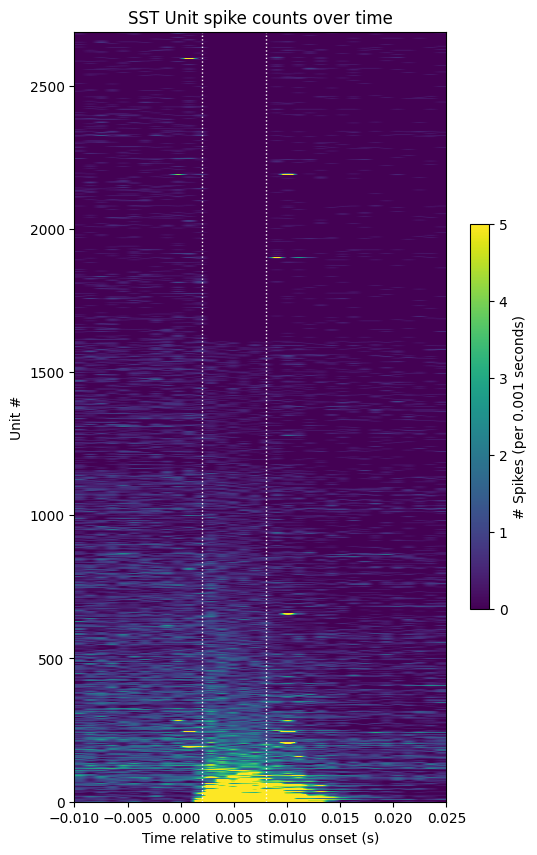

In [19]:
unit_response_means = np.mean(sst_spike_counts[:, sst_stim_start:sst_stim_end], axis=1)
sorted_respons_idxs = np.argsort(unit_response_means)
sorted_sst_spike_counts = np.take(sst_spike_counts, sorted_respons_idxs, axis=0)

show_counts(sorted_sst_spike_counts,
            sst_bin_edges,
            stim_bounds=[censor_period, stim_duration-censor_period],
            title="sorted SST Unit spike counts over time",
            c_label=f"# Spikes (per {time_resolution} seconds)",
            vmin=0,
            vmax=5)

### Identifying Optotagged Units
Now that the `spike_counts` array has been made, several other plots can be generated as well. Below, the mean and the standard deviation are taken for each unit of the baseline spiking behavior before any stimulus is presented.

#### Responsive Unit Spike Counts

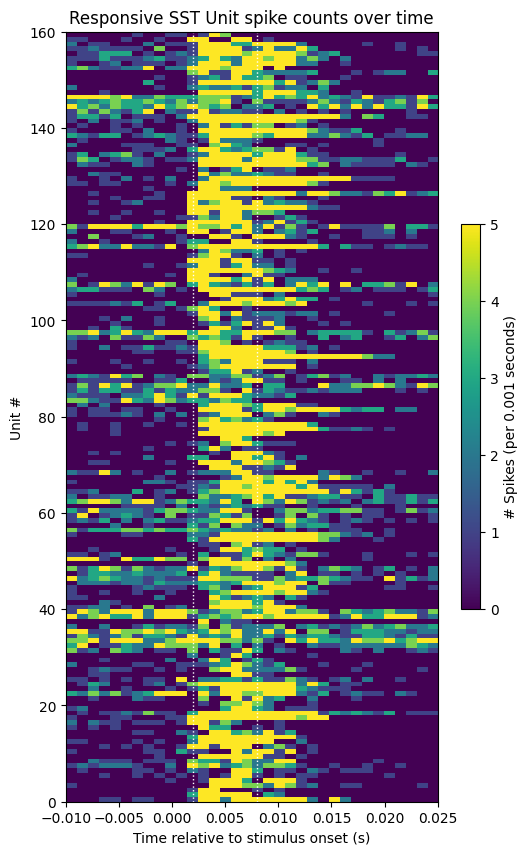

In [20]:
# show activity of units with a mean response during stim period greater than 2
show_counts(sst_spike_counts[unit_response_means > 2],
            sst_bin_edges,
            stim_bounds=[censor_period, stim_duration-censor_period],
            title="Responsive SST Unit spike counts over time",
            c_label=f"# Spikes (per {time_resolution} seconds)",
            vmin=0,
            vmax=5)

### Calculating Unit Optotagging Metrics
Here, certain metrics are calculated for each unit based on their spiking behaviors in response to the stimulus. Metrics such as these are used to identify if a unit is "optotagged". i.e if a unit is responsive to the laser, and thus is a genetically modified inhibitory neuron. There is no single standard for what metrics to use for determining optotagged units, but the ones below may prove useful. You can adapt this code to calculate additional metrics for the units as well. Each function below calculates a metric (or two) for a given unit. As input, they use the `spike_counts`, and `spike_matrix` arrays which were already generated earlier, as well as the `stim_times` and `units_spike_times` which were produced from the NWB file. Finally, these metrics are displayed for each unit table below.

Among the metrics below, the response spike rate, fraction time responsive, fraction trials responsive, and ks salt value are likely to be higher if the unit is optotagged. The first spike latency and first spike jitter are likely to be lower if the unit is optotagged.

In [21]:
# utility function used by first_spike_latencies_and_jitters and ks_salt
# returns an array of length 'start_times' with the first spike time after each `start_time` (and the censor period)
def get_first_spikes_after_onset(spike_times, start_times):
    response_start_times = start_times[start_times < spike_times.max()]

    first_spike_idxs = np.searchsorted(spike_times, response_start_times)
    first_spike_times = spike_times[first_spike_idxs] - response_start_times
    first_spike_times += censor_period
    
    return first_spike_times


def first_spike_latencies_and_jitters(spike_times, start_times):
    first_spike_times = get_first_spikes_after_onset(spike_times, start_times)
    
    first_spike_jitter = median_abs_deviation(first_spike_times)
    first_spike_latency = np.median(first_spike_times)
    
    return first_spike_jitter, first_spike_latency


def ks_salt(spike_times, start_times):
    first_spikes = get_first_spikes_after_onset(spike_times, start_times)
 
    # get first spikes at some time sufficiently prior the stimulus times so as to be a baseline period
    # but not too far back, for risk of sampling time during a previous stimulus event
    baseline_spikes = get_first_spikes_after_onset(spike_times, start_times-0.01)
    
    try:
        return kstest(first_spikes, baseline_spikes)[1]
    except:
        return np.nan

In [22]:
def fraction_time_responsive(unit_idx, spike_matrix, bl_trial_counts, stim_start_idx, stim_end_idx):
    bl_mean_count = np.mean(bl_trial_counts)
    
    bins_pvals = []
    bins_above_baseline = []
    
    for bin_idx in range(stim_start_idx, stim_end_idx):
        time_bin = spike_matrix[unit_idx, :, bin_idx]
        bins_pvals.append(mannwhitneyu(bl_trial_counts, time_bin)[1])
        bins_above_baseline.append(np.mean(time_bin) > bl_mean_count)

    num_sig_bins = np.sum( (np.array(bins_pvals)<0.01) & np.array(bins_above_baseline) )
    fraction_sig_bins = num_sig_bins / (stim_end_idx-stim_start_idx)
    return fraction_sig_bins


def fraction_trials_responsive(unit_idx, spike_matrix, bl_trial_counts, stim_start_idx, stim_end_idx, n_trials):
    bl_mean_count = np.mean(bl_trial_counts)
    
    trials_pvals = []
    trials_above_baseline = []
    
    for trial_idx in range(n_trials):
        trial = spike_matrix[unit_idx, trial_idx, stim_start_idx:stim_end_idx]
        trials_pvals.append(mannwhitneyu(bl_trial_counts, trial)[1])
        trials_above_baseline.append(np.mean(trial) > bl_mean_count)

    num_sig_trials = np.sum( (np.array(trials_pvals)<0.01) & np.array(trials_above_baseline) )
    fraction_sig_trials = num_sig_trials / n_trials
    return fraction_sig_trials

In [23]:
def get_opto_metrics(stim_times, units_spike_times, spike_counts, spike_matrix, censor_period, stim_start_idx, stim_end_idx, bl_start_idx, bl_end_idx):
    n_units = len(units_spike_times)
    n_trials = len(stim_times)
    start_times = np.array(stim_times) + censor_period

    # get mean response spike rate for each unit
    avg_spikes = spike_counts[:,stim_start_idx:stim_end_idx] / n_trials
    mean_response_spike_rates = np.mean(avg_spikes, axis=1)

    # these will be populated for each unit
    first_spike_jitters = np.zeros((n_units))
    first_spike_latencies = np.zeros((n_units))
    fracs_time_responsive = np.zeros((n_units))
    fracs_trials_responsive = np.zeros((n_units))
    salts = np.zeros((n_units))

    # populate each optotagging metric array for each unit
    for unit_idx in range(n_units):
        spike_times = units_spike_times[unit_idx]

        first_spike_jitter, first_spike_latency = first_spike_latencies_and_jitters(spike_times, start_times)

        first_spike_jitters[unit_idx] = first_spike_jitter
        first_spike_latencies[unit_idx] = first_spike_latency
        salts[unit_idx] = ks_salt(spike_times, start_times)

        # use the mean baseline spike counts for each trial to determine when the unit is 'responsive'
        bl_trial_counts = np.mean(spike_matrix[unit_idx, :, bl_start_idx:bl_end_idx], axis=0)
        fracs_time_responsive[unit_idx] = fraction_time_responsive(unit_idx, spike_matrix, bl_trial_counts, stim_start_idx, stim_end_idx)
        fracs_trials_responsive[unit_idx] = fraction_trials_responsive(unit_idx, spike_matrix, bl_trial_counts, stim_start_idx, stim_end_idx, n_trials)

    return mean_response_spike_rates, first_spike_jitters, first_spike_latencies, fracs_time_responsive, fracs_trials_responsive, salts

In [24]:
opto_metrics = get_opto_metrics(sst_stim_times, sst_spike_times, sst_spike_counts, sst_spike_matrix, censor_period, sst_stim_start, sst_stim_end, sst_bl_start, sst_bl_end)
mean_response_spike_rates, first_spike_jitters, first_spike_latencies, fracs_time_responsive, fracs_trials_responsive, salts = opto_metrics

df = pd.DataFrame({"mean response spike rate": mean_response_spike_rates,
                   "first spike jitter": first_spike_jitters,
                   "first spike latency": first_spike_latencies,
                   "fraction time responsive": fracs_time_responsive,
                   "fraction trials responsive": fracs_trials_responsive,
                   "ks salt value": salts
                  })
df

,mean response spike rate,first spike jitter,first spike latency,fraction time responsive,fraction trials responsive,ks salt value
0,0.002222,0.096366,0.127574,0.166667,0.0,9.966899e-01
1,0.002222,1.669213,1.985956,0.000000,0.0,1.000000e+00
2,0.004444,0.145623,0.181877,0.333333,0.0,9.717333e-01
3,0.000000,0.108815,0.168240,0.000000,0.0,9.999465e-01
4,0.000000,1.579199,1.937359,0.000000,0.0,1.000000e+00
...,...,...,...,...,...,...
2683,0.095556,0.006178,0.009724,0.333333,0.0,4.072687e-10
2684,0.022222,1.551573,1.562273,0.000000,0.0,8.503638e-04
2685,0.002222,3.681344,4.311915,0.000000,0.0,2.937247e-01
2686,0.011111,1.958318,2.226296,0.000000,0.0,9.999465e-01
